In [ ]:
import numpy as np
from sympy import symbols
from contextlib import redirect_stdout
import subprocess
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from mpmath import mp
import datetime
import copy

In [2]:
#Set up mpmath here
mp.prec = 200 # Sets the precision of calculations in bits
print(mp)

Mpmath settings:
  mp.prec = 200               [default: 53]
  mp.dps = 59                 [default: 15]
  mp.trap_complex = False     [default: False]


In [3]:
class SDPAWrapper:
    def __init__(self):
        self.status = None
        self.oval = None
        self.xval = None
    
    def run(self, file='aho'):
        args = ['sdpa_gmp',f'{file}.dat',f'{file}.result']
        subprocess.run(args, stdout=subprocess.DEVNULL)
        with open(f'{file}.result','r') as f:
            lines = f.readlines()
            for lpos, line in enumerate(lines):
                if line.startswith('phase.value'):
                    self.status = line.split(' ')[2]
                if line.startswith('objValPrimal'):
                    self.oval = np.double(line.split(' ')[2])
                if line.startswith('xVec'):
                    self.xval = np.array(lines[lpos + 1][1:-2].split(','), dtype=np.double)

# You do not need to create any more instances of this class
# SDPARunObject runs the data file and stores the status, objective value, and the values of the optimization variables
SDPARunObject = SDPAWrapper()

In [4]:
class Problem:
    def __init__(self, K, problem_name):
        self._K = K
        self._name = problem_name
        self._basis = None
        self._freevars = None
        self._freevars_index_map = None
        self._index_freevars_map = None
        self._E = symbols('E')

    def _initialize_basis(self):
        raise NotImplementedError

    def _implement_recursion(self):
        raise NotImplementedError

    def _get_free_variables(self):
        raise NotImplementedError

    def initialize_problem(self):
        self._initialize_basis()
        self._implement_recursion()
        self._get_free_variables()
    
    def _generate_sdpa_matrices(self):
        raise NotImplementedError
    
    def _write_input(self, energy, file):
        raise NotImplementedError

    def solve(self, energy, write_to_log=True):
        with open('not_opt.log','a') as logfile:
            with open('aho.dat','w') as datafile:
                self._write_input(energy, datafile)
            SDPARunObject.run()
            if write_to_log == True and SDPARunObject.status != 'pdOPT':
                logfile.write(f'[{datetime.datetime.now()}]: name={self._name} | K={self._K} | status={SDPARunObject.status} | energy={energy}\n')
            return SDPARunObject.oval


In [5]:
class HankelProblem(Problem):
    def __init__(self, K, problem_name):
        super().__init__(K, problem_name)
        self._internal_matrix = None
    
    def _get_free_variables(self):
        self._freevars = set()
        for v1 in self._basis:
            for v2 in v1:
                self._freevars |= v2.free_symbols
        # The energy is not a free variable
        self._freevars.discard(self._E)

        # Map each free variable to a number
        self._freevars_index_map = dict()
        self._index_freevars_map = dict()
        for i, fvar in enumerate(self._freevars):
            self._freevars_index_map[fvar] = i
            self._index_freevars_map[i] = fvar
    
    def _generate_internal_matrix_structure(self):
        raise NotImplementedError

    def initialize_problem(self):
        super().initialize_problem()
        self._generate_internal_matrix_structure()
    
    def _internal_matrix_energy_substitution(self, energy):
        M = copy.deepcopy(self._internal_matrix)
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                M[i, j] = M[i, j].subs([(self._E, energy)])
        return M
    
    def _generate_sdpa_matrices(self, energy):
        M = self._internal_matrix_energy_substitution(energy)
        # [F0] + [F1,...,Fc] + [t]
        Fs = [np.zeros_like(M)] + [np.zeros_like(M) for _ in range(len(self._freevars))] + [np.eye(M.shape[0])]
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                term = M[i, j]
                for t, coeff in term.as_coefficients_dict().items():
                    if t == 1:
                        Fs[0][i, j] -= np.double(coeff)
                        continue
                    Fs[1 + self._freevars_index_map[t]][i, j] += np.double(coeff)
        return Fs

    def _write_input(self, energy, file):
        flatten = lambda xss: [x for xs in xss for x in xs]
        with redirect_stdout(file):
            print(f'*Energy: {energy}')
            print('*Potential name: ' + self._name)
            print(1 + len(self._freevars)) # mDIM
            print(1) # nBLOCK
            print(self._internal_matrix.shape[0]) # bLOCKsTRUCT
            c = np.zeros(1 + len(self._freevars))
            c[-1] = 1
            print(*c)
            Fs = self._generate_sdpa_matrices(energy)
            for F in Fs:
                print(*flatten(F.tolist()))

In [101]:
class SUSYProblem(HankelProblem):
    """
    Solves H = p^2 + A(x) - B(x)[P, P\dag].
    A(x) and B(x) are polynomials provided as coefficient lists.
    """
    # def __init__(self, K, problem_name, A, B):
    #     super().__init__(K, problem_name)
    #     self._A = A
    #     self._B = B
    def _initialize_basis(self):
        self._basis = [None] * 2
        self._basis[0] = [symbols(f'x_{i}') for i in range(2*self._K)]
        self._basis[1] = [symbols(f'x_{i}PP^^') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x_0': 1})

        # Recursion for <x>
        for t in range(1, len(self._basis[0]) - 3):
            self._basis[0][t+3] = 4*t*self._E*self._basis[0][t-1] #+ (4*t+2)*self._basis[1][t]
            if t >= 3:
                self._basis[0][t+3] += t*(t-1)*(t-2)*self._basis[0][t-3]
            self._basis[0][t+3] /= (t+2)
            self._basis[0][t+3].simplify()
        # Recursion for <xPP^^>
        for t in range(1, len(self._basis[0]) - 3):
            self._basis[1][t+3] = 4*t*self._E*self._basis[1][t-1] + (4*t+2)*self._basis[0][t]
            if t >= 3:
                self._basis[1][t+3] += t*(t-1)*(t-2)*self._basis[1][t-3]
            self._basis[1][t+3] /= (t+2)
            self._basis[1][t+3].simplify()
    
    def _generate_internal_matrix_structure(self):
        M0 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        M1 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<xPP^^>

        for i in range(self._K):
            for j in range(self._K):
                # M0
                M0[i, j] = self._basis[0][i + j]
                # M2
                M1[i, j] = self._basis[1][i + j]

        self._internal_matrix = np.bmat(
            [[M0, M1],
             [M1, M1]])
    
    def solve(self, energy, write_to_log=True):
        oval = super().solve(energy, write_to_log)
        x2b = SDPARunObject.xval[self._freevars_index_map[symbols('x_2')]]
        x2f = SDPARunObject.xval[self._freevars_index_map[symbols('x_2PP^^')]]
        return oval, x2b, x2f

In [102]:
class NonSUSYProblem(HankelProblem):
    """
    Solves H = p^2 + x^4/4.
    """
    def _initialize_basis(self):
        self._basis = [None]
        self._basis[0] = [symbols(f'x_{i}') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x_0': mp.mpf('1')})

        # Recursion for <x>
        for t in mp.arange(1, len(self._basis[0]) - 3):
            ti = int(t)
            self._basis[0][ti+3] = 4*t*self._E*self._basis[0][ti-1]
            if t >= 3:
                self._basis[0][ti+3] += t*(t-1)*(t-2)*self._basis[0][ti-3]
            self._basis[0][ti+3] /= (t+2)
            self._basis[0][ti+3].simplify()
    
    def _generate_internal_matrix_structure(self):
        self._internal_matrix = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        for i in range(self._K):
            for j in range(self._K):
                self._internal_matrix[i, j] = self._basis[0][i + j]

In [103]:
def solve(problem, Es):
    vals = []
    for E in Es:
        vals.append(problem.solve(E))
    return np.array(vals)

In [ ]:
p = NonSUSYProblem(10, 'x4pot')
p.initialize_problem()

In [80]:
Es = np.linspace(0, 6, num=200)
ts = solve(p, Es)

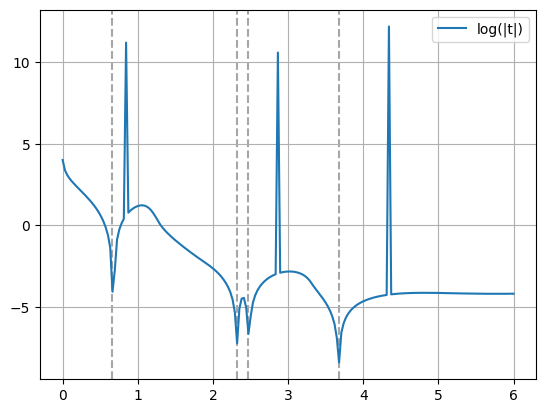

In [ ]:
plt.plot(Es, np.log(np.fabs(ts)), label='log(|t|)')
dips = Es[find_peaks(-np.log(np.fabs(ts)),prominence=1)[0]]
for dip in dips:
    plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
plt.grid()
plt.legend()
plt.show()

In [104]:
p = SUSYProblem(10, 'x4pot')
p.initialize_problem()

In [105]:
Es = np.linspace(0, 6, num=200)
vals = solve(p, Es)

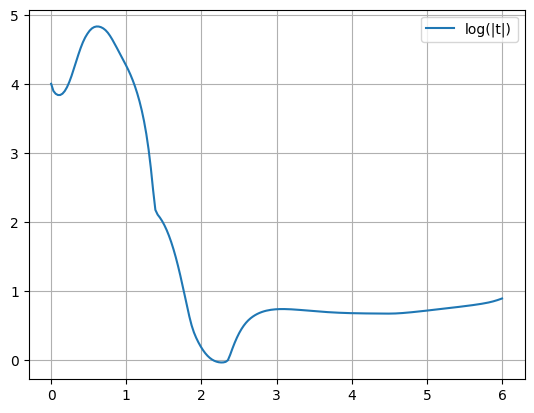

In [108]:
plt.plot(Es, np.log(np.fabs(vals[:, 0])), label='log(|t|)')
# plt.plot(Es, x2bs, label='<x^2>')
# plt.plot(Es, x2fs, label='<x^2PP\dag>')
# plt.plot(Es, x2fs/x2bs, label='ratio')
dips = Es[find_peaks(-np.log(np.fabs(vals[:, 0])),prominence=1)[0]]
for dip in dips:
    plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
plt.grid()
plt.legend()
plt.show()

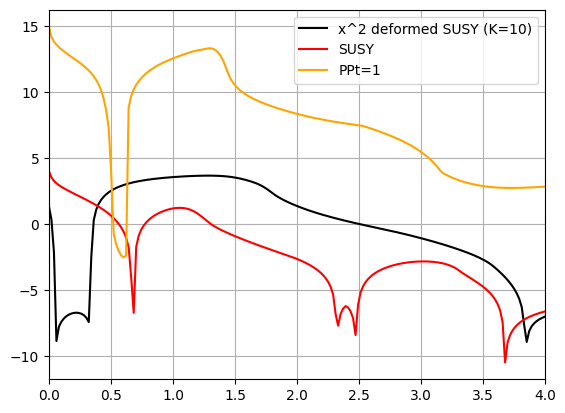

In [45]:
# data = np.load(f'./data/susy_x4_deform_one_particle_K_10.npz',allow_pickle=True)
# plt.plot(data['Es'], np.log(np.fabs(data['ts'])),c='red',label='Deformed SUSY (K=10)')
data = np.load(f'./data/susy_x4pot_deformx2_g_1.0_K_10.npz',allow_pickle=True)
plt.plot(data['Es'], np.log(np.fabs(data['ts'])),c='black',label='x^2 deformed SUSY (K=10)')
# data = np.load(f'./data/susy_test_non_susy_x4_K_10_shift_0.npz',allow_pickle=True)
# plt.plot(data['Es'], data['ts']+3,c='orange',label='Non SUSY+3')
data = np.load(f'./data/susy_x4_one_particle.npz',allow_pickle=True)
plt.plot(data['Es'], np.log(np.fabs(data['ts'])),c='red',label='SUSY')
plt.plot(Es, np.log(np.fabs(ts)),c='orange',label='PPt=1')
plt.xlim(0,4)
# plt.plot(Es, PPts)
plt.grid()
plt.legend()
plt.show()